## Gluing

Esse notebook faz o gluing to sinal analógico com a cotagem de fótons.
Uma faixa considerada adequada do sinal e foton couting é de 0.5 a 10 MHZ
upper signal é o sinal distante (photon counting). Lower signal é o sinal próximo (analog)

### Read data and imports

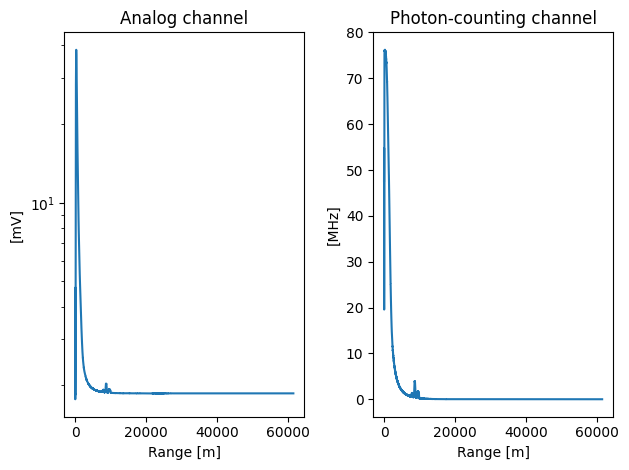

In [1]:
from importlib import reload

import numpy as np
from scipy.stats import shapiro, anderson, probplot

from matplotlib import pyplot as plt
%matplotlib inline

#from lidar_processing import fit_checks; reload(fit_checks)
#from lidar_processing import pre_processing; reload(pre_processing)

from lifa.processing import fit_checks; reload(fit_checks)
from lifa.processing import pre_processing; reload(pre_processing)

# Read input data
f = np.loadtxt(r'..\tests\tests_data\processing\sample_profiles_532_an_ph.txt')
z = f[:, 0]
signal_an = f[:, 1]
signal_ph = f[:, 2]
# Convert photon count to photon count rate
bin_width = 25 #3.75 m bin -> 25ns
files = 134
signal_ph = signal_ph/(bin_width*files)


plt.subplot(121)
plt.title('Analog channel')
plt.yscale('log')

plt.plot(z, signal_an)
plt.xlabel('Range [m]')
plt.ylabel('[mV]')

plt.subplot(122)
plt.title('Photon-counting channel')

plt.plot(z, signal_ph)
plt.xlabel('Range [m]')
plt.ylabel('[MHz]')

plt.tight_layout()
#plt.savefig('example_channels.png', dpi=150)

### Correção deadtime. Licel é modelado pela correção nonparalyzable

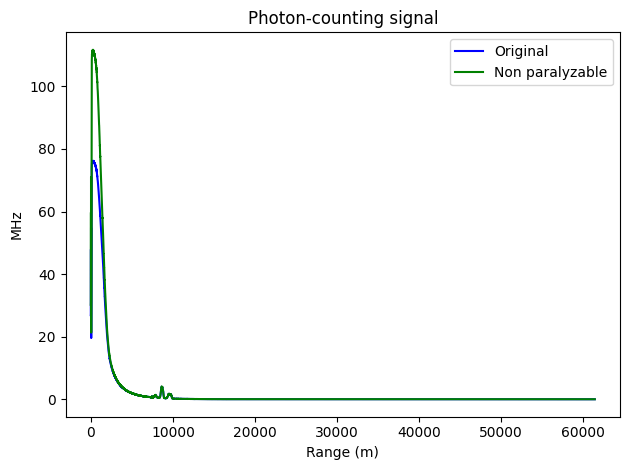

In [ ]:
dead_time = 1/500 #(1/500 MHz = 2ns - deatime estimado é por volta de 3 a 4 ns)
non_paralyzable_corrected = pre_processing.correct_count_rate_dead_time_nonparalyzable(signal_ph, dead_time)

plt.title('Photon-counting signal')
plt.plot(z, signal_ph, 'b', label='Original')
plt.plot(z, non_paralyzable_corrected, 'g', label='Non paralyzable')
plt.xlabel('Range (m)'); plt.ylabel('MHz')
plt.legend()
plt.tight_layout()
#plt.savefig('deadtime.png', dpi=150)

### Background subtraction

In [9]:
# Background subtracted analog
backround_removed_analog, background_mean, background_std = \
        pre_processing.subtract_background(signal_an, idx_min=14000, idx_max=16000)

# Background subtracted photon
backround_removed_photon, background_mean_photon, background_std__photon = \
        pre_processing.subtract_background(non_paralyzable_corrected, idx_min=14000, idx_max=16000)

print("Analog background:\nMean: {}\nStd: {}".format(background_mean, background_std))
print("Photon background:\nMean: {}\nStd: {}".format(background_mean_photon, background_std__photon))


Analog background:
Mean: 1.86588758
Std: 0.000123563520506656
Photon background:
Mean: 3.462691505168613e-05
Std: 0.00010320952590837289


### Trigger delay

Text(0, 0.5, 'Virtual count rate (MHz)')

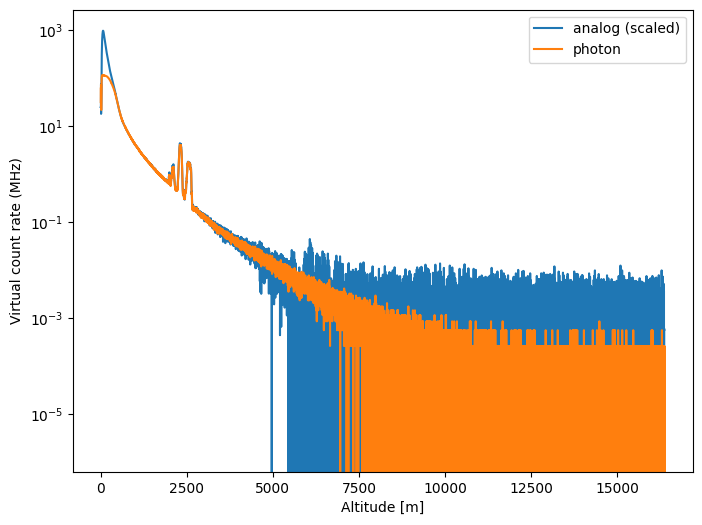

In [10]:
# Apply the correcte trigger delay
trigger_delay_ns = -250
trigger_delay_analog = pre_processing.correct_trigger_delay_ns(backround_removed_analog, 
                                                                         z, 
                                                                         trigger_delay_ns)


upper_signal = backround_removed_photon
lower_signal = trigger_delay_analog

scale_factor = np.sum(upper_signal[1000:1500]) / np.sum(lower_signal[1000:1500])

plt.figure(figsize=(8, 6))
plt.plot(lower_signal * scale_factor, label='analog (scaled)')
plt.plot(upper_signal, label='photon')


plt.yscale('log')
plt.legend()
plt.xlabel('Altitude [m]')
plt.ylabel('Virtual count rate (MHz)')
#plt.ylim(0, 10)
#plt.xlim(3500, 4000)

### Gluing indicators

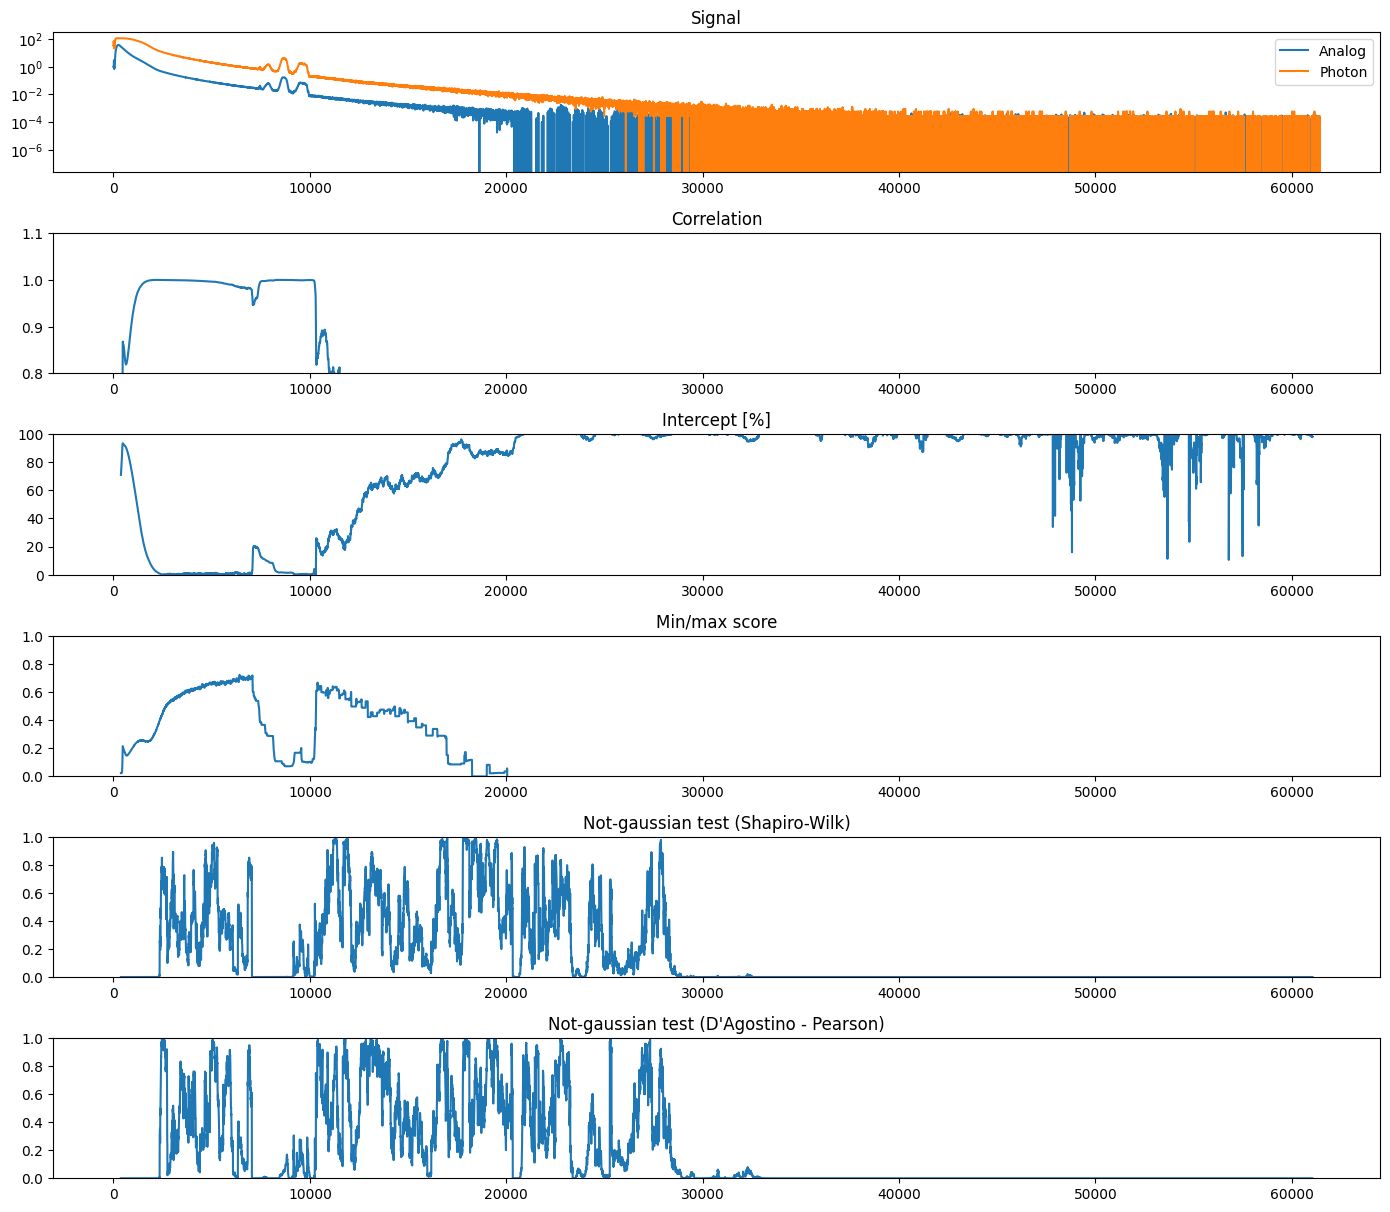

In [12]:
window_length = 200

# correlação entre os dois sinais (pproximo de 1 é bom), e valor de interceptação da regreção linear. Próximo de zero é bom (os sinais são diferentes por uma multiplicacao)
# correlation_mask = correlation_values > correlation_threshold
# intercept_mask = intercept_values < intercept_threshold
intercept_values, correlation_values = fit_checks.sliding_check_linear_fit_intercept_and_correlation(lower_signal, upper_signal, window_length)

# Checa se os residuais seguem uma distribuição gaussiana (ruido). Se valor for menor que limiar, significa que a distribuição é não gaussina - ruim
# not_gaussian_mask = gaussian_values < gaussian_threshold
not_gaussian_values = fit_checks.sliding_check_residuals_not_gaussian(lower_signal, upper_signal, window_length)

# Razão dos valores máximos e minimos
#minmax_ratio_large_mask = minmax_ratio_values > minmax_threshold
minmax_values = fit_checks.sliding_check_min_max_ratio(lower_signal, upper_signal, window_length)

# Outra foram de avaliar se os residuos são gaussianos
dagostino_values = fit_checks.sliding_check_residuals_not_gaussian_dagostino(lower_signal, upper_signal, window_length)

plt.figure(figsize=(14, 14))

ax1 = plt.subplot(711)
plt.plot(z, lower_signal, label = "Analog")
plt.plot(z, upper_signal, label = "Photon")
plt.legend()
plt.title('Signal')
plt.yscale('log')

plt.subplot(712, sharex=ax1)
plt.plot(z, correlation_values)

plt.ylim(0.8, 1.1)
plt.title('Correlation')

plt.subplot(713, sharex=ax1)
plt.plot(z, intercept_values)
plt.ylim(0, 100)
plt.title('Intercept [%]')

plt.subplot(714, sharex=ax1)
plt.plot(z, minmax_values)
plt.title('Min/max score')
plt.ylim(0, 1)

plt.subplot(715, sharex=ax1)
plt.plot(z, not_gaussian_values)
plt.title('Not-gaussian test (Shapiro-Wilk)')
plt.ylim(0, 1)

plt.subplot(716, sharex=ax1)
plt.plot(z, dagostino_values)
plt.title("Not-gaussian test (D'Agostino - Pearson)")
plt.ylim(0, 1)


#plt.xlim(1000, 15000)
plt.tight_layout()

### Gluing

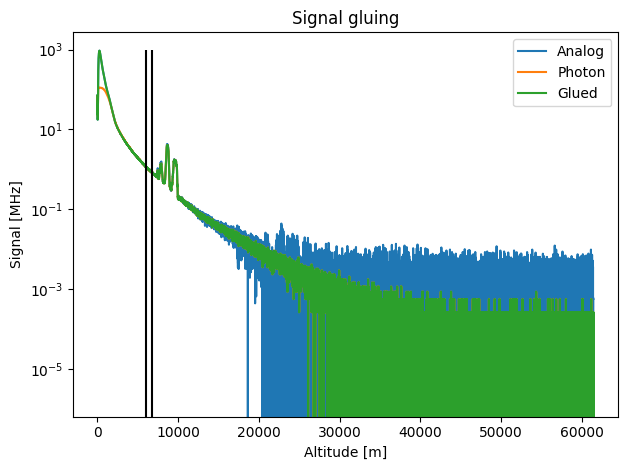

In [13]:
window_length = 200
correlation_threshold = 0.95
intercept_threshold = 0.5
gaussian_threshold = 0.2
minmax_threshold = 0.5
min_idx = None
max_idx = None


glued_signal, gluing_std, gluing_central_idx, score, c_lower, c_upper = pre_processing.glue_signals_1d(lower_signal, 
                                                                       upper_signal, 
                                                                       window_length,
                                                                       correlation_threshold, 
                                                                       intercept_threshold, 
                                                                       gaussian_threshold,
                                                                       minmax_threshold,
                                                                       min_idx, 
                                                                       max_idx,
                                                                       use_upper_as_reference=True)

#plt.figure(figsize=(4, 2.5))
plt.plot(z,lower_signal * c_lower, label='Analog')
plt.plot(z, upper_signal, label='Photon')
plt.plot(z, glued_signal, label='Glued')

plt.xlabel('Altitude [m]')
plt.ylabel('Signal [MHz]')

ylims = plt.ylim()
plt.vlines([z[gluing_central_idx - window_length//2], z[gluing_central_idx + window_length//2]], ylims[0], ylims[1], 'k')

plt.legend()

plt.title('Signal gluing')
plt.tight_layout()
plt.yscale('log')


### Gluing region analisys
Idealmente a razão entre os dois sinais deve ser 1. E o grafico de um pelo outro deve ser uma linha

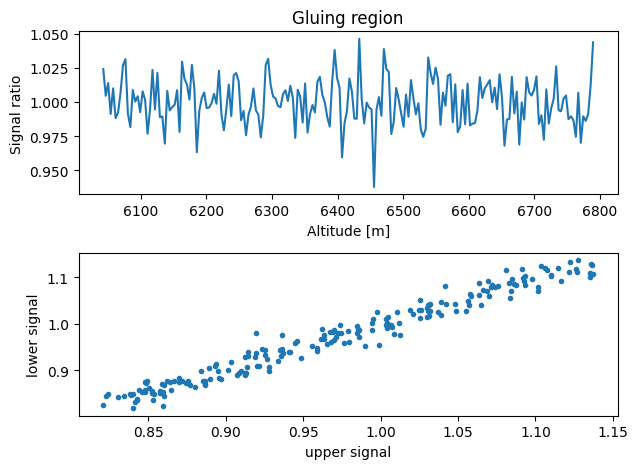

In [14]:
signal_ratio = (upper_signal * c_upper) / (lower_signal * c_lower)

idx_min = int(gluing_central_idx - window_length/2)
idx_max = int(gluing_central_idx + window_length/2)

plt.subplot(211)

plt.plot(z[idx_min:idx_max], signal_ratio[idx_min:idx_max])
plt.xlabel('Altitude [m]')
plt.ylabel('Signal ratio')

plt.title('Gluing region')

plt.subplot(212)

plt.plot(upper_signal[idx_min:idx_max] * c_upper,  lower_signal[idx_min:idx_max] * c_lower, '.')
plt.xlabel('upper signal')
plt.ylabel('lower signal')

plt.tight_layout()
